<a href="https://colab.research.google.com/github/messi10tom/news-recommendation/blob/main/matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# creating dataset
"""
we need dataframe to be: user_id | news_id | rating

ie.       |news_1 | news_2 | news_3  .....  | news_n |
   user_1 | 1     | 2      | 3       .....  | 10     |
   user_2 | 4     | 5      | 6       .....  | 9      |
   user_3 | 7     | 8      | 9       .....  | 3      |
          :       :        :                :        :
          :       :        :                :        :
   user_n | 10    | 11     | 12      .....  | 5      |


rating ε [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
         not liked                liked
"""

n_users = 50
n_news = 100

np.random.seed(42)
ratings = np.random.randint(1, 10, size=(n_news))
user_id = np.random.randint(1, n_users, size=(n_news))
news_id = np.random.randint(1, n_news, size=(n_news))

print(f"number of users: {n_users}")
print(f"number of news: {n_news}")
print(ratings)
print(user_id)
print(news_id)

number of users: 50
number of news: 100
[7 4 8 5 7 3 7 8 5 4 8 8 3 6 5 2 8 6 2 5 1 6 9 1 3 7 4 9 3 5 3 7 5 9 7 2 4
 9 2 9 5 2 4 7 8 3 1 4 2 8 4 2 6 6 4 6 2 2 4 8 7 9 8 5 2 5 8 9 9 1 9 7 9 8
 1 8 8 3 1 8 3 3 1 5 7 9 7 9 8 2 1 7 7 8 5 3 8 6 3 1]
[35 37 47 14  3  1  5 26 14 39 27  9 15 15 26 42 13 32 39 49 32  4 30 37
 23 39 45 15 43 29 36 13 32  7 22 28  2 42 45  6 28 28 44 44 20 30 11 28
 25 39 33  1 27 13 41  3 39  6  8 27  9 37 33 42 44 24 15 32 32 24 41 49
 49 12 39  2  3 49 37 49 17 49  2  2 28 23 37 32 33  1 19  2 44 26 32  6
 32  4 11 17]
[38 24 69 98 70 86 11 16 97 73 59 70 80 93  3 20 59 36 19 90 67 19 20 96
 71 52 33 40 39 82  1 11 92 57 89 50 23 31 94 42 99  7 16 90 60  2  1 48
 12 69 37 32  9 99 19 48 80  3 20 24 54 33 24 75 72 36 38 84 99 89 99 25
 93 18 82 66 54 35 80 61 41 33 68 33 14 21 48 20  8  7 67 17 33 48 76 59
 86 22 30 38]


<ipython-input-44-b315649b7c58>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


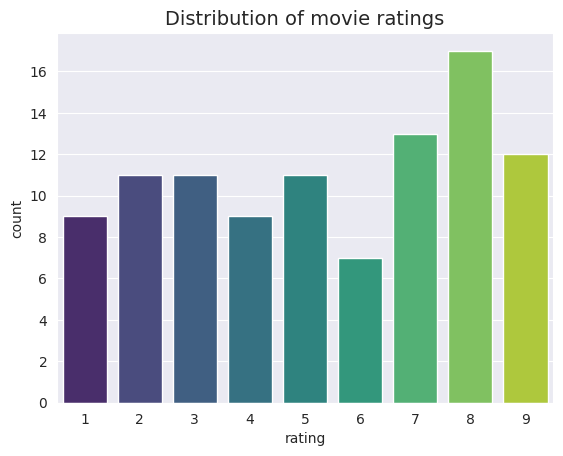

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ratings = pd.DataFrame(data={"user_id": user_id, "news_id": news_id, "rating": ratings})


sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [ ]:
print(f"Mean global rating: {(ratings['rating'].mean())}.")
print(f"Median global rating: {(ratings['rating'].median())}.")
print(f"Standard deviation of global ratings: {(ratings['rating'].std())}.")

ratings.head()

Mean global rating: 5.32.
Median global rating: 5.0.
Standard deviation of global ratings: 2.639559191848656.


,user_id,news_id,rating
0,35,38,7
1,37,24,4
2,47,69,8
3,14,98,5
4,3,70,7


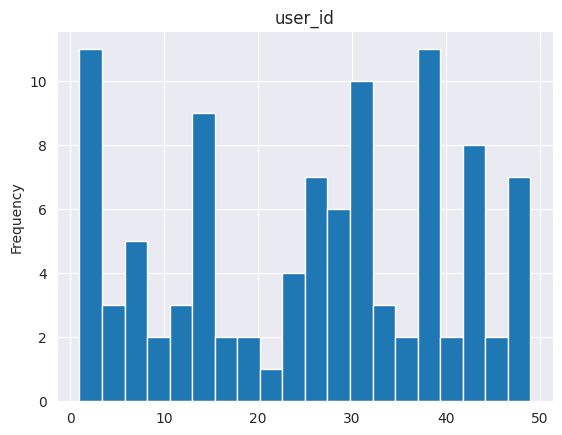

In [ ]:
# @title user_id

ratings['user_id'].plot(kind='hist', bins=20, title='user_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [59]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


embed_dim = 5
batchsize = 32
epoch = 100

user_embed = Embedding(n_users, embed_dim)
news_embed = Embedding(n_news, embed_dim)
user_optimizer = Adam(learning_rate=0.01)
news_optimizer = Adam(learning_rate=0.01)
lossOBJ = MeanSquaredError()

In [62]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings, test_size=0.2)
dataset = tf.data.Dataset.from_tensor_slices((train.user_id, train.news_id, train.rating))
dataset.shuffle(10000)
dataset = dataset.batch(batchsize)

validation = tf.data.Dataset.from_tensor_slices((test.user_id, test.news_id, test.rating))
validation = validation.batch(1)

In [60]:
# optimizing
for i in range(epoch):
  for user, news, rating in dataset:
    with tf.GradientTape() as user_tape, tf.GradientTape() as news_tape:
      user_embedding = user_embed(user)
      news_embedding = news_embed(news)
      loss = lossOBJ(rating, tf.reduce_sum(user_embedding * news_embedding, axis=1))
    user_grad = user_tape.gradient(loss, user_embed.trainable_variables)
    news_grad = news_tape.gradient(loss, news_embed.trainable_variables)
    user_optimizer.apply_gradients(zip(user_grad, user_embed.trainable_variables))
    news_optimizer.apply_gradients(zip(news_grad, news_embed.trainable_variables))
  if i % 10 == 0:
    print(f"Epoch {i}, Loss: {loss}")
  # break

Epoch 0, Loss: 37.57714080810547
Epoch 10, Loss: 35.32103729248047
Epoch 20, Loss: 26.050594329833984
Epoch 30, Loss: 12.719792366027832
Epoch 40, Loss: 3.6768078804016113
Epoch 50, Loss: 0.679069459438324
Epoch 60, Loss: 0.10260207951068878
Epoch 70, Loss: 0.02037344127893448
Epoch 80, Loss: 0.0070424629375338554
Epoch 90, Loss: 0.0033928235061466694


In [78]:
for user, news, rating in validation:
  user_embedding = user_embed(user)
  news_embedding = news_embed(news)
  predicted = (tf.reduce_sum(user_embedding * news_embedding, axis=1))
  loss = tf.round(lossOBJ(rating, predicted))
  print(f"Rating: {rating[0]}, Predicted: {predicted[0]} loss: {loss}")


Rating: 5, Predicted: 5.007743835449219 loss: 0.0
Rating: 5, Predicted: 4.954391956329346 loss: 0.0
Rating: 3, Predicted: 3.00900936126709 loss: 0.0
Rating: 1, Predicted: 1.0119221210479736 loss: 0.0
Rating: 7, Predicted: 7.014701843261719 loss: 0.0
Rating: 7, Predicted: 6.931973457336426 loss: 0.0
Rating: 7, Predicted: 6.98931884765625 loss: 0.0
Rating: 6, Predicted: 5.990716934204102 loss: 0.0
Rating: 5, Predicted: -0.02784682810306549 loss: 25.0
Rating: 6, Predicted: 6.250720500946045 loss: 0.0
Rating: 9, Predicted: 8.902460098266602 loss: 0.0
Rating: 7, Predicted: 6.996280670166016 loss: 0.0
Rating: 6, Predicted: 6.039678573608398 loss: 0.0
Rating: 2, Predicted: 2.0004186630249023 loss: 0.0
Rating: 8, Predicted: 8.022404670715332 loss: 0.0
Rating: 6, Predicted: 5.995837688446045 loss: 0.0
Rating: 9, Predicted: 9.418416023254395 loss: 0.0
Rating: 3, Predicted: 2.9998934268951416 loss: 0.0
Rating: 8, Predicted: 7.966640472412109 loss: 0.0
Rating: 9, Predicted: -0.04312789440155029 lo